In [1]:
# UNet Training Pipeline for Histopathology Segmentation
# ========================================================

import sys
import torch
import torch.nn as nn
import numpy as np

# Import UNet from CNNs folder
from CNNs.UNet import UNet

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))

PyTorch version: 2.9.1+cu128
CUDA available: True
CUDA device: NVIDIA RTX A5000


In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize UNet model for multi-class segmentation (5 tissue types)
print("\nInitializing UNet model...")
model = UNet(
    in_channels=3,       # RGB input
    out_channels=5,      # 5 tissue classes
    base_filters=64,     # Base number of filters
    depth=4,             # 4 downsampling/upsampling levels
    bilinear=False       # Use transposed convolutions
)

print("✓ UNet model initialized successfully!")

Using device: cuda

Initializing UNet model...
✓ UNet model initialized successfully!


In [3]:
# Get model information
model_info = model.get_model_info()

print("="*80)
print("UNET MODEL INFORMATION")
print("="*80)

for key, value in model_info.items():
    if 'parameters' in key:
        print(f"{key}: {value:,}")
    else:
        print(f"{key}: {value}")

# Test forward pass
print("\n" + "="*80)
print("TEST FORWARD PASS")
print("="*80)
test_input = torch.randn(2, 3, 224, 224)
with torch.no_grad():
    test_output = model(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {test_output.shape}")
print(f"Expected: [2, 5, 224, 224]")
print("✓ Forward pass successful!" if test_output.shape == (2, 5, 224, 224) else "✗ Shape mismatch!")

UNET MODEL INFORMATION
architecture: UNet
input_channels: 3
output_channels: 5
base_filters: 64
depth: 4
bilinear_upsampling: False
total_parameters: 31,037,893
trainable_parameters: 31,037,893

TEST FORWARD PASS
Input shape: torch.Size([2, 3, 224, 224])
Output shape: torch.Size([2, 5, 224, 224])
Expected: [2, 5, 224, 224]
✓ Forward pass successful!


In [4]:
# Import additional libraries for training
import pandas as pd
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
import os
from datetime import datetime

print("Training libraries imported!")

Training libraries imported!


In [5]:
# Load dataset and preprocess
df = pd.read_csv('Dataset/Images_With_Unique_Labels_Refer_Segmentation_Task.csv')
print(f"Dataset loaded: {len(df)} samples")
print(f"\nColumns: {df.columns.tolist()}")

# Parse classes into binary columns
class_names = ['Neoplastic', 'Inflammatory', 'Connective_Soft_tissue', 'Epithelial', 'Dead']

for class_name in class_names:
    df[class_name] = df['classes'].apply(lambda x: 1 if class_name in x else 0)

# Add mask paths - masks follow pattern: {base_name}_channel_{idx}_{class_name}.png
df['base_name'] = df['image_path'].str.replace('_img.png', '')

print(f"\nClass distribution:")
for col in class_names:
    count = df[col].sum()
    print(f"  {col}: {count} ({count/len(df)*100:.1f}%)")

Dataset loaded: 2720 samples

Columns: ['image_id', 'image_path', 'classes', 'organ', 'classes_clean', 'instruction']

Class distribution:
  Neoplastic: 2229 (81.9%)
  Inflammatory: 2326 (85.5%)
  Connective_Soft_tissue: 2652 (97.5%)
  Epithelial: 1061 (39.0%)
  Dead: 231 (8.5%)


In [6]:
# Custom Dataset Class (same as temp.ipynb)
class HistopathologyDataset(Dataset):
    def __init__(self, dataframe, img_dir='Dataset/multi_images', mask_dir='Dataset/multi_masks', 
                 transform=None, img_size=224):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.img_size = img_size
        self.class_names = ['Neoplastic', 'Inflammatory', 'Connective_Soft_tissue', 'Epithelial', 'Dead']
        self.channel_mapping = {
            'Neoplastic': 0,
            'Inflammatory': 1,
            'Connective_Soft_tissue': 2,
            'Dead': 3,
            'Epithelial': 4
        }
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load image
        img_path = os.path.join(self.img_dir, row['image_path'])
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Load masks for each class (following channel naming convention)
        base_name = row['base_name']
        masks = []
        
        for class_name in self.class_names:
            channel_idx = self.channel_mapping[class_name]
            mask_filename = f"{base_name}_channel_{channel_idx}_{class_name}.png"
            mask_path = os.path.join(self.mask_dir, mask_filename)
            
            if os.path.exists(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = (mask > 127).astype(np.uint8)  # Binarize
            else:
                # If mask doesn't exist, create empty mask
                mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
            
            masks.append(mask)
        
        # Stack masks: [H, W, num_classes]
        masks = np.stack(masks, axis=-1)
        
        # Apply augmentations
        if self.transform:
            augmented = self.transform(image=image, mask=masks)
            image = augmented['image']
            masks = augmented['mask']
        
        # Convert to tensors
        if isinstance(image, np.ndarray):
            image = torch.from_numpy(image).permute(2, 0, 1).float()
        elif isinstance(image, torch.Tensor) and image.ndim == 3 and image.shape[-1] == 3:
            image = image.permute(2, 0, 1).float()
        
        if isinstance(masks, np.ndarray):
            masks = torch.from_numpy(masks).permute(2, 0, 1).float()
        elif isinstance(masks, torch.Tensor) and masks.ndim == 3 and masks.shape[-1] == len(self.class_names):
            masks = masks.permute(2, 0, 1).float()
        
        # Get class presence (binary vector)
        class_presence = torch.tensor([row[cls] for cls in self.class_names], dtype=torch.float32)
        
        return {
            'image': image,
            'masks': masks,
            'class_presence': class_presence,
            'image_name': row['image_path']
        }

print("Dataset class defined!")

Dataset class defined!


In [7]:
# Define augmentations
train_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Custom collate function
def custom_collate(batch):
    images = []
    masks = []
    class_presence = []
    image_names = []
    
    for item in batch:
        images.append(item['image'])
        mask = item['masks']
        if mask.shape[0] != 5:
            mask = mask.permute(2, 0, 1)
        masks.append(mask)
        class_presence.append(item['class_presence'])
        image_names.append(item['image_name'])
    
    return {
        'image': torch.stack(images),
        'masks': torch.stack(masks),
        'class_presence': torch.stack(class_presence),
        'image_name': image_names
    }

# Train-val split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[class_names].sum(axis=1))
print(f"Train samples: {len(train_df)}")
print(f"Val samples: {len(val_df)}")

# Create datasets
train_dataset = HistopathologyDataset(train_df, transform=train_transform)
val_dataset = HistopathologyDataset(val_df, transform=val_transform)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, 
                          pin_memory=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, 
                        pin_memory=True, collate_fn=custom_collate)

print(f"\nDataLoaders created!")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train samples: 2176
Val samples: 544

DataLoaders created!
Train batches: 68
Val batches: 17


In [8]:
# Metrics: Dice Score and IoU
def dice_score(pred, target, smooth=1e-6, per_class=False):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    
    if per_class:
        return dice.mean(dim=0)
    else:
        return dice.mean()

def iou_score(pred, target, smooth=1e-6, per_class=False):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    
    if per_class:
        return iou.mean(dim=0)
    else:
        return iou.mean()

# Combined Loss: BCE + Dice Loss
class CombinedLoss(nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super().__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce = nn.BCEWithLogitsLoss()
        
    def dice_loss(self, pred, target, smooth=1e-6):
        pred = torch.sigmoid(pred)
        intersection = (pred * target).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
        dice = (2. * intersection + smooth) / (union + smooth)
        return 1 - dice.mean()
    
    def forward(self, pred, target):
        bce = self.bce(pred, target)
        dice = self.dice_loss(pred, target)
        return self.bce_weight * bce + self.dice_weight * dice

print("Metrics and loss functions defined!")

Metrics and loss functions defined!


In [9]:
# Training Configuration
config = {
    'num_epochs': 10,
    'learning_rate': 1e-4,
    'weight_decay': 1e-5,
    'device': device,
    'save_dir': 'checkpoints',
    'best_model_path': 'checkpoints/best_unet_model.pth',
}

os.makedirs(config['save_dir'], exist_ok=True)

model = model.to(config['device'])
criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)
optimizer = AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
scheduler = CosineAnnealingLR(optimizer, T_max=config['num_epochs'], eta_min=1e-6)

print("Training configuration set!")
print(f"Device: {config['device']}")
print(f"Epochs: {config['num_epochs']}")
print(f"Learning rate: {config['learning_rate']}")

Training configuration set!
Device: cuda
Epochs: 10
Learning rate: 0.0001


In [10]:
# Training and Validation Functions for UNet
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    
    class_names = ['Neoplastic', 'Inflammatory', 'Connective', 'Epithelial', 'Dead']
    num_classes = len(class_names)
    
    running_loss = 0.0
    running_dice = torch.zeros(num_classes)
    running_iou = torch.zeros(num_classes)
    
    pbar = tqdm(loader, desc='Training', leave=False)
    for batch in pbar:
        images = batch['image'].to(device)
        masks = batch['masks'].to(device)
        
        # Forward pass (UNet only takes images, no text)
        optimizer.zero_grad()
        pred_masks = model(images)  # Direct output [B, 5, H, W]
        
        # Calculate loss
        loss = criterion(pred_masks, masks)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Calculate metrics
        with torch.no_grad():
            pred_sigmoid = torch.sigmoid(pred_masks)
            dice_per_class = dice_score(pred_sigmoid, masks, per_class=True)
            iou_per_class = iou_score(pred_sigmoid, masks, per_class=True)
        
        running_loss += loss.item()
        running_dice += dice_per_class.cpu()
        running_iou += iou_per_class.cpu()
        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'dice': f'{dice_per_class.mean().item():.4f}',
            'iou': f'{iou_per_class.mean().item():.4f}'
        })
    
    epoch_loss = running_loss / len(loader)
    epoch_dice = running_dice / len(loader)
    epoch_iou = running_iou / len(loader)
    
    return epoch_loss, epoch_dice, epoch_iou

def validate_epoch(model, loader, criterion, device):
    model.eval()
    
    class_names = ['Neoplastic', 'Inflammatory', 'Connective', 'Epithelial', 'Dead']
    num_classes = len(class_names)
    
    running_loss = 0.0
    running_dice = torch.zeros(num_classes)
    running_iou = torch.zeros(num_classes)
    
    pbar = tqdm(loader, desc='Validation', leave=False)
    with torch.no_grad():
        for batch in pbar:
            images = batch['image'].to(device)
            masks = batch['masks'].to(device)
            
            # Forward pass (UNet only takes images)
            pred_masks = model(images)  # Direct output [B, 5, H, W]
            
            # Calculate loss
            loss = criterion(pred_masks, masks)
            
            # Calculate metrics
            pred_sigmoid = torch.sigmoid(pred_masks)
            dice_per_class = dice_score(pred_sigmoid, masks, per_class=True)
            iou_per_class = iou_score(pred_sigmoid, masks, per_class=True)
            
            running_loss += loss.item()
            running_dice += dice_per_class.cpu()
            running_iou += iou_per_class.cpu()
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'dice': f'{dice_per_class.mean().item():.4f}',
                'iou': f'{iou_per_class.mean().item():.4f}'
            })
    
    epoch_loss = running_loss / len(loader)
    epoch_dice = running_dice / len(loader)
    epoch_iou = running_iou / len(loader)
    
    return epoch_loss, epoch_dice, epoch_iou

print("Training and validation functions defined!")

Training and validation functions defined!


In [11]:
# Main Training Loop
class_names = ['Neoplastic', 'Inflammatory', 'Connective', 'Epithelial', 'Dead']

history = {
    'train_loss': [], 'train_dice': [], 'train_iou': [],
    'val_loss': [], 'val_dice': [], 'val_iou': []
}

best_val_dice = 0.0
start_time = datetime.now()

print("="*80)
print("STARTING UNET TRAINING")
print("="*80)
print(f"Start time: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Batch size: {batch_size}")
print("="*80)

for epoch in range(config['num_epochs']):
    print(f"\nEpoch [{epoch+1}/{config['num_epochs']}]")
    print("-" * 80)
    
    # Train
    train_loss, train_dice, train_iou = train_epoch(
        model, train_loader, criterion, optimizer, config['device']
    )
    
    # Validate
    val_loss, val_dice, val_iou = validate_epoch(
        model, val_loader, criterion, config['device']
    )
    
    # Update learning rate
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_dice'].append(train_dice.mean().item())
    history['train_iou'].append(train_iou.mean().item())
    history['val_loss'].append(val_loss)
    history['val_dice'].append(val_dice.mean().item())
    history['val_iou'].append(val_iou.mean().item())
    
    # Print epoch summary
    print(f"\n{'Metric':<20} {'Train':>12} {'Val':>12}")
    print("-" * 47)
    print(f"{'Loss':<20} {train_loss:>12.4f} {val_loss:>12.4f}")
    print(f"{'Dice Score (Mean)':<20} {train_dice.mean():>12.4f} {val_dice.mean():>12.4f}")
    print(f"{'IoU Score (Mean)':<20} {train_iou.mean():>12.4f} {val_iou.mean():>12.4f}")
    
    # Print per-class metrics
    print(f"\n{'Class':<20} {'Train Dice':>12} {'Val Dice':>12} {'Train IoU':>12} {'Val IoU':>12}")
    print("-" * 77)
    for i, class_name in enumerate(class_names):
        print(f"{class_name:<20} {train_dice[i]:>12.4f} {val_dice[i]:>12.4f} {train_iou[i]:>12.4f} {val_iou[i]:>12.4f}")
    
    print(f"\n{'Learning Rate':<20} {current_lr:>12.6f}")
    
    # Save best model
    val_dice_mean = val_dice.mean().item()
    if val_dice_mean > best_val_dice:
        best_val_dice = val_dice_mean
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_dice': val_dice_mean,
            'val_dice_per_class': val_dice.tolist(),
            'val_iou': val_iou.mean().item(),
            'val_loss': val_loss,
        }, config['best_model_path'])
        print(f"✓ Best model saved! (Mean Dice: {val_dice_mean:.4f})")

end_time = datetime.now()
training_time = end_time - start_time

print("\n" + "="*80)
print("TRAINING COMPLETED!")
print("="*80)
print(f"End time: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Training duration: {training_time}")
print(f"Best validation Dice score: {best_val_dice:.4f}")
print(f"Best model saved at: {config['best_model_path']}")
print("="*80)

STARTING UNET TRAINING
Start time: 2025-12-20 18:33:22
Training samples: 2176
Validation samples: 544
Batch size: 32

Epoch [1/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]


Metric                      Train          Val
-----------------------------------------------
Loss                       0.7776       0.7412
Dice Score (Mean)          0.1038       0.2256
IoU Score (Mean)           0.0812       0.2079

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.1641       0.1842       0.1119       0.1334
Inflammatory               0.1054       0.2714       0.0917       0.2708
Connective                 0.0874       0.0821       0.0499       0.0459
Epithelial                 0.0230       0.0020       0.0137       0.0010
Dead                       0.1392       0.5882       0.1390       0.5882

Learning Rate            0.000098
✓ Best model saved! (Mean Dice: 0.2256)

Epoch [2/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]


Metric                      Train          Val
-----------------------------------------------
Loss                       0.7308       0.7242
Dice Score (Mean)          0.3349       0.4462
IoU Score (Mean)           0.3155       0.4276

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.1961       0.2130       0.1430       0.1590
Inflammatory               0.5037       0.5682       0.5025       0.5673
Connective                 0.0998       0.0878       0.0577       0.0496
Epithelial                 0.1144       0.4393       0.1138       0.4393
Dead                       0.7606       0.9228       0.7606       0.9228

Learning Rate            0.000091
✓ Best model saved! (Mean Dice: 0.4462)

Epoch [3/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]


Metric                      Train          Val
-----------------------------------------------
Loss                       0.7054       0.6932
Dice Score (Mean)          0.4781       0.5138
IoU Score (Mean)           0.4641       0.5024

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.2061       0.2172       0.1524       0.1632
Inflammatory               0.5722       0.5864       0.5720       0.5864
Connective                 0.0413       0.0263       0.0265       0.0233
Epithelial                 0.6539       0.7776       0.6530       0.7776
Dead                       0.9168       0.9614       0.9168       0.9614

Learning Rate            0.000080
✓ Best model saved! (Mean Dice: 0.5138)

Epoch [4/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]


Metric                      Train          Val
-----------------------------------------------
Loss                       0.6844       0.6773
Dice Score (Mean)          0.5050       0.5059
IoU Score (Mean)           0.4944       0.4946

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.2017       0.2195       0.1512       0.1649
Inflammatory               0.5662       0.5474       0.5654       0.5467
Connective                 0.1280       0.1320       0.1268       0.1307
Epithelial                 0.7023       0.7077       0.7015       0.7077
Dead                       0.9269       0.9228       0.9269       0.9228

Learning Rate            0.000066

Epoch [5/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]


Metric                      Train          Val
-----------------------------------------------
Loss                       0.6681       0.6607
Dice Score (Mean)          0.5133       0.5221
IoU Score (Mean)           0.5018       0.5102

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.2229       0.2441       0.1703       0.1890
Inflammatory               0.4800       0.4620       0.4757       0.4586
Connective                 0.1785       0.2002       0.1777       0.1994
Epithelial                 0.7528       0.7739       0.7528       0.7739
Dead                       0.9324       0.9301       0.9324       0.9301

Learning Rate            0.000051
✓ Best model saved! (Mean Dice: 0.5221)

Epoch [6/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]


Metric                      Train          Val
-----------------------------------------------
Loss                       0.6553       0.6810
Dice Score (Mean)          0.5184       0.4715
IoU Score (Mean)           0.5055       0.4585

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.2355       0.2370       0.1794       0.1802
Inflammatory               0.4530       0.4022       0.4466       0.3967
Connective                 0.1861       0.1245       0.1843       0.1216
Epithelial                 0.7782       0.7298       0.7781       0.7298
Dead                       0.9393       0.8640       0.9393       0.8640

Learning Rate            0.000035

Epoch [7/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]


Metric                      Train          Val
-----------------------------------------------
Loss                       0.6467       0.6444
Dice Score (Mean)          0.5113       0.5161
IoU Score (Mean)           0.4974       0.5028

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.2493       0.2605       0.1910       0.2030
Inflammatory               0.4211       0.4260       0.4112       0.4191
Connective                 0.1767       0.1661       0.1750       0.1641
Epithelial                 0.7739       0.7887       0.7739       0.7886
Dead                       0.9357       0.9393       0.9357       0.9393

Learning Rate            0.000021

Epoch [8/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]


Metric                      Train          Val
-----------------------------------------------
Loss                       0.6407       0.6380
Dice Score (Mean)          0.5143       0.5147
IoU Score (Mean)           0.4999       0.5003

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.2642       0.2752       0.2049       0.2182
Inflammatory               0.4285       0.3907       0.4194       0.3796
Connective                 0.1612       0.1502       0.1575       0.1461
Epithelial                 0.7786       0.8054       0.7785       0.8053
Dead                       0.9393       0.9522       0.9393       0.9522

Learning Rate            0.000010

Epoch [9/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]


Metric                      Train          Val
-----------------------------------------------
Loss                       0.6374       0.6357
Dice Score (Mean)          0.5089       0.5157
IoU Score (Mean)           0.4926       0.4995

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.2670       0.2656       0.2074       0.2074
Inflammatory               0.4202       0.4055       0.4103       0.3972
Connective                 0.1307       0.1555       0.1192       0.1410
Epithelial                 0.7829       0.8070       0.7828       0.8070
Dead                       0.9435       0.9449       0.9435       0.9449

Learning Rate            0.000003

Epoch [10/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]


Metric                      Train          Val
-----------------------------------------------
Loss                       0.6359       0.6359
Dice Score (Mean)          0.5112       0.5068
IoU Score (Mean)           0.4927       0.4886

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.2662       0.2673       0.2059       0.2092
Inflammatory               0.4263       0.3753       0.4174       0.3637
Connective                 0.1390       0.1522       0.1158       0.1310
Epithelial                 0.7827       0.7997       0.7827       0.7996
Dead                       0.9416       0.9393       0.9416       0.9393

Learning Rate            0.000001

TRAINING COMPLETED!
End time: 2025-12-20 18:39:39
Training duration: 0:06:16.621058
Best validation Dice score: 0.5221
Best model saved at: checkpoints/best_unet_model.pth


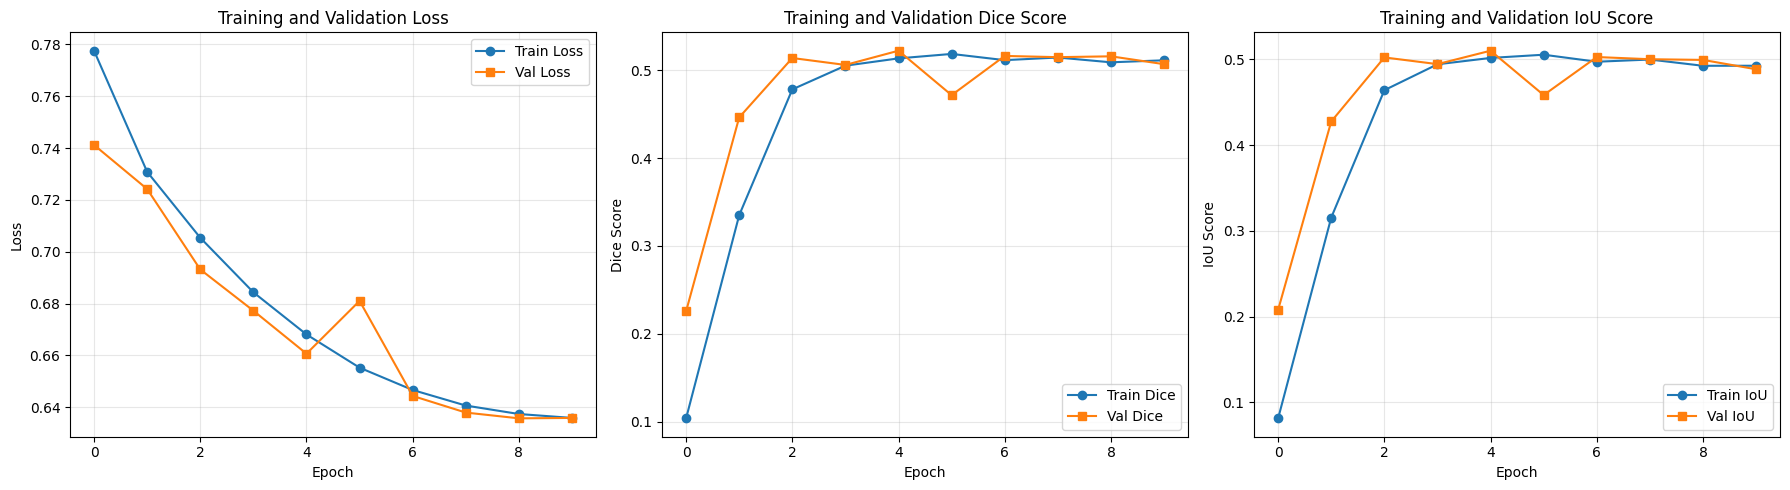

Training history plotted!


In [12]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['train_dice'], label='Train Dice', marker='o')
axes[1].plot(history['val_dice'], label='Val Dice', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice Score')
axes[1].set_title('Training and Validation Dice Score')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(history['train_iou'], label='Train IoU', marker='o')
axes[2].plot(history['val_iou'], label='Val IoU', marker='s')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('IoU Score')
axes[2].set_title('Training and Validation IoU Score')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Training history plotted!")

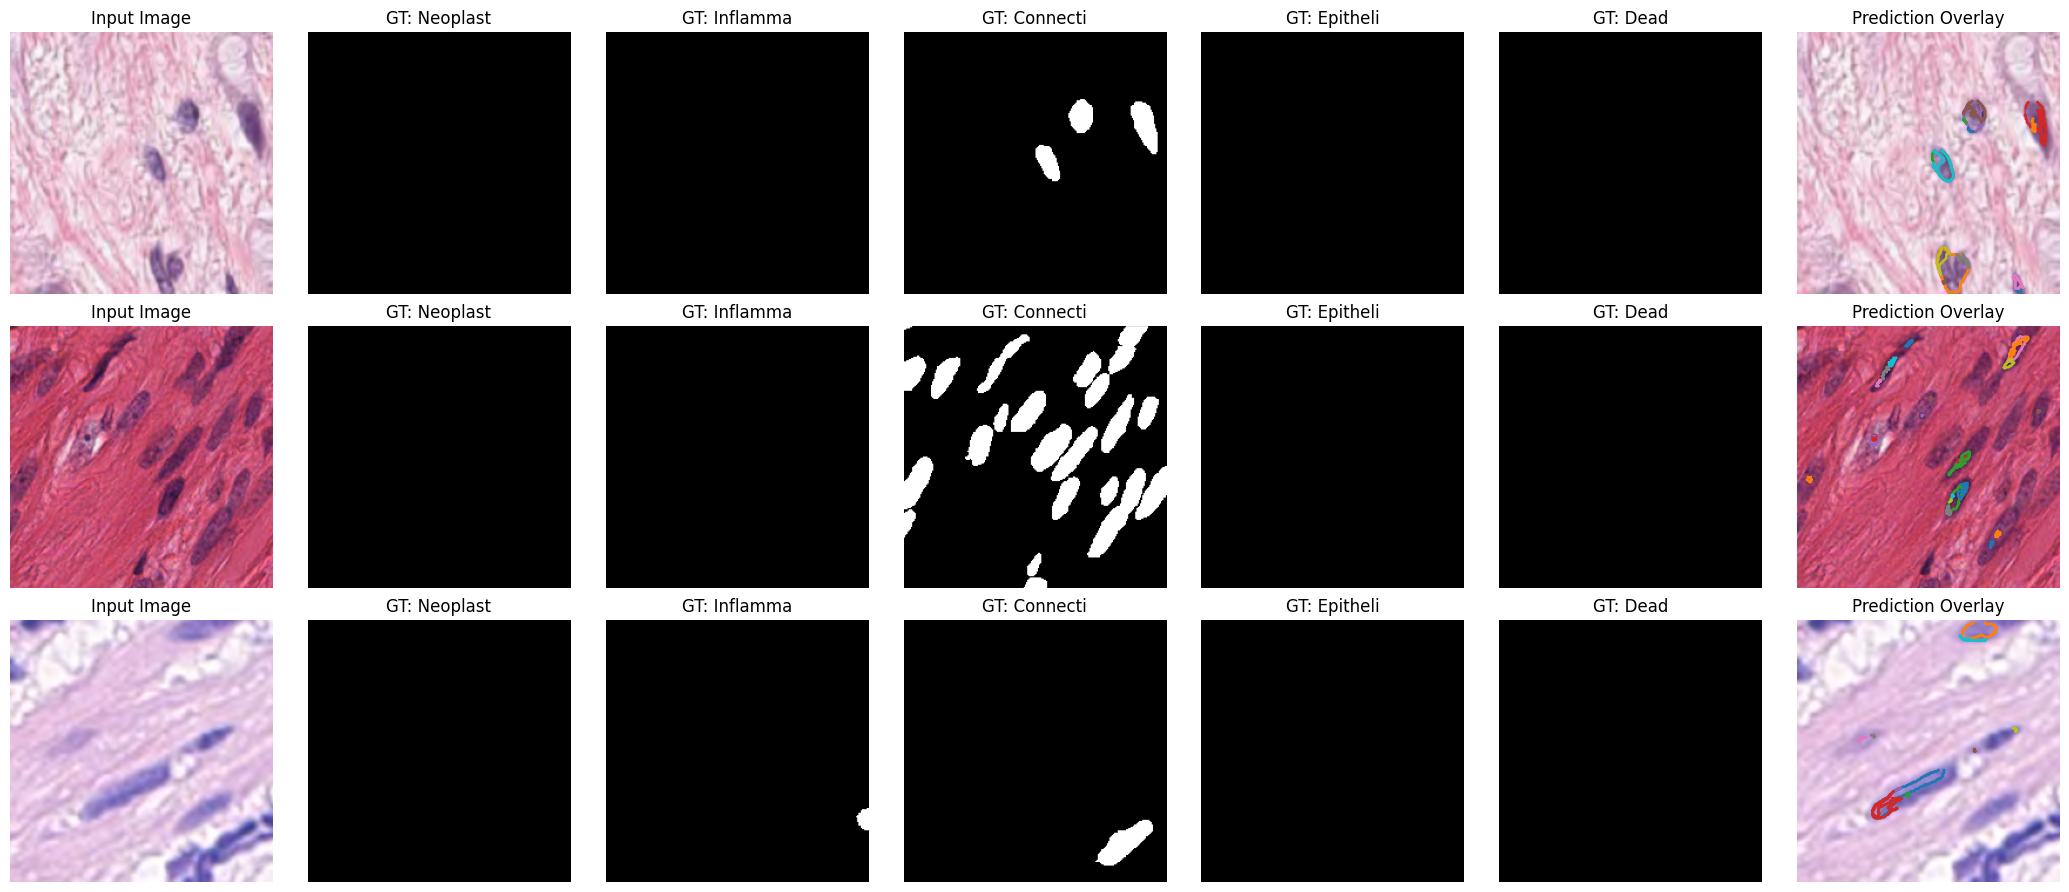

Predictions visualized!


In [13]:
# Visualize sample predictions
def visualize_predictions(model, dataset, device, num_samples=3):
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 7, figsize=(21, 3*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    class_names = ['Neoplastic', 'Inflammatory', 'Connective', 'Epithelial', 'Dead']
    
    with torch.no_grad():
        for i in range(num_samples):
            idx = np.random.randint(0, len(dataset))
            sample = dataset[idx]
            
            image = sample['image'].unsqueeze(0).to(device)
            gt_masks = sample['masks']  # [5, H, W]
            
            # Get prediction (UNet - no text input needed)
            pred_masks = torch.sigmoid(model(image)[0])  # [5, H, W]
            pred_masks = pred_masks.cpu()
            
            # Denormalize image for visualization
            img_display = image[0].cpu().permute(1, 2, 0).numpy()
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img_display = img_display * std + mean
            img_display = np.clip(img_display, 0, 1)
            
            # Plot image
            axes[i, 0].imshow(img_display)
            axes[i, 0].set_title('Input Image')
            axes[i, 0].axis('off')
            
            # Plot GT masks
            for j in range(5):
                axes[i, j+1].imshow(gt_masks[j], cmap='gray', vmin=0, vmax=1)
                axes[i, j+1].set_title(f'GT: {class_names[j][:8]}')
                axes[i, j+1].axis('off')
            
            # Overlay prediction
            axes[i, 6].imshow(img_display)
            for j in range(5):
                mask_pred = (pred_masks[j] > 0.5).numpy()
                if mask_pred.sum() > 0:
                    contours = cv2.findContours((mask_pred*255).astype(np.uint8), 
                                               cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
                    for contour in contours:
                        contour = contour.squeeze()
                        if len(contour) > 2:
                            axes[i, 6].plot(contour[:, 0], contour[:, 1], linewidth=2)
            axes[i, 6].set_title('Prediction Overlay')
            axes[i, 6].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_predictions(model, val_dataset, device, num_samples=3)
print("Predictions visualized!")